# Sentiments towards COVID-19 Vaccine in South Africa _Embedding training

## Background
What were we trying to achieve? What are the key results/insights did we obtain? How did we get to these insights? What data was used and how was it processed? 

In [90]:
# Importing useful packages
import pandas as pd
import numpy as np
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
#from stop_words import get_stop_words
#import re
#from english_words import english_words_set
from collections import Counter
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#nltk.download(Stopwords)
#Embedding dependencies
import gensim
from gensim.models import word2vec
import multiprocessing

In [2]:
# Normalizing data
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

In [3]:
# Reading dataframes with tokenized sentences for training word embeddings
df_replies = pd.read_csv('replies_dataframe.csv').drop('Unnamed: 0',axis =1)
df_comments = pd.read_csv('comments_dataframe.csv').drop('Unnamed: 0',axis =1)

In [4]:
# Retrieving the tokenized sentences for embedding training
replies_retrieved = [list(df_replies.iloc[i].dropna().astype('str')) for i in range(df_replies.shape[0])]
comments_retrieved = [list(df_comments.iloc[i].dropna().astype('str')) for i in range(df_comments.shape[0])]

In [45]:
# For the replies to the comments
replies_retrieved = [replies_retrieved[i]  for i in range(len(replies_retrieved)) if len(replies_retrieved[i]) > 0]
embedding_replies = word2vec.Word2Vec(sentences = replies_retrieved,size = 100, min_count = 1,window=3)
reply_vectors = embedding_replies.wv
vaccine_closewords_replies = reply_vectors.similar_by_word('vaccine')
print(f'Most similar to vaccine are {vaccine_closewords_replies[:3]}')

Most similar to vaccine are [('don', 0.9986127018928528), ('people', 0.998603343963623), ('just', 0.9985694289207458)]


In [46]:
# Training Word Embeddings using gensim an NLP library
# For direct comments only
embedding_comments  = word2vec.Word2Vec(sentences = comments_retrieved,size = 100, min_count = 1,window=3)
comment_vectors = embedding_comments.wv
vaccine_closewords_comments = comment_vectors.similar_by_word('vaccine')
print(f'Most similar to vaccine are {vaccine_closewords_comments[:4]}')

Most similar to vaccine are [('people', 0.9730865359306335), ('can', 0.9697962999343872), ('will', 0.9666574001312256), ('just', 0.9627724885940552)]


In [47]:
# For both replies and comments combined
comments_replies_combined = replies_retrieved + comments_retrieved
embedding_combined = word2vec.Word2Vec(sentences = comments_replies_combined,size = 100, min_count = 1,window=3)
combined_vectors = embedding_combined.wv
vaccine_closewords_combined = combined_vectors.similar_by_word('vaccine')
print(f'Most similar to vaccine are {vaccine_closewords_combined[:4]}')

Most similar to vaccine are [('can', 0.9999226927757263), ('people', 0.9999063611030579), ('just', 0.9999061226844788), ('will', 0.9999046921730042)]


In [92]:
gensim.models.keyedvectors

<module 'gensim.models.keyedvectors' from '/home/felix/Documents/Environments/Deep_learning_env/lib/python3.7/site-packages/gensim/models/keyedvectors.py'>

## Plotting the embedding dimensions with PCA

In [35]:
# example way of obtaining word embeddings. 
# 'Lets check the embedding of the word vaccine in all the embeddings'
#model = Word2Vec(tokens,size=50,sg=1,min_count=1)
#print(comment_vectors["vaccine"])
#print(reply_vectors['vaccine'])
#print(combined_vectors['vaccine'])

In [48]:
# printing the learnt vocabulary
reply_words=list(reply_vectors.wv.vocab)
comment_words=list(comment_vectors.wv.vocab)
combined_words=list(combined_vectors.wv.vocab)

#print(reply_words)

In [101]:
# Creating data frames for use in plotting PCA components

#Getting the word embeddings
X_replies = reply_vectors[reply_vectors.wv.vocab]
X_comments = comment_vectors[comment_vectors.wv.vocab]
X_combined = combined_vectors[combined_vectors.wv.vocab]

#Standardize for PCA
X_replies_standard = standard.fit_transform(X_replies)
X_comments_standard = standard.fit_transform(X_comments)
X_combined_standard = standard.fit_transform(X_combined)

#Creating dataframes with words as index and columns representing each embedding dimension
replies_df = pd.DataFrame(X_replies_standard,index=reply_words)
comments_df = pd.DataFrame(X_comments_standard,index=comment_words)
combined_df = pd.DataFrame(X_combined_standard,index=combined_words)


In [50]:
def pca(df):
    #Computing the correlation matrix
    X_corr=df.corr()

    #Computing eigen values and eigen vectors
    values,vectors=np.linalg.eig(X_corr)

    #Sorting the eigen vectors coresponding to eigen values in descending order
    args = (-values).argsort()
    values = vectors[args]
    vectors = vectors[:, args]

    #Taking first 2 components which explain maximum variance for projecting
    new_vectors=vectors[:,:2]

    #Projecting it onto new dimesion with 2 axis
    neww_X=np.dot(df.values,new_vectors)
    return neww_X

In [51]:
# PCA on dataframe
reply_components = pca(replies_df)
comment_components = pca(comments_df)
combined_components = pca(combined_df)

In [53]:
# Plotting function
def plotting_components_mod(components,model, no_words = 20):
    """no_words: The number of words you want to display on visualization"""
    plt.figure(figsize=(13,7))
    plt.scatter(components[:no_words,0],components[:no_words,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title("Word Embedding Space",size=20)
    vocab=list(model.wv.vocab)[:no_words]
    for i, word in enumerate(vocab):
        plt.annotate(word,xy=(components[i,0],components[i,1]))



In [137]:
# Plotting function for words around a word of interest
def plotting_components(components,words_for_plot):
    plt.figure(figsize=(13,7))
    plt.scatter(components[0,0],components[0,1],linewidths=10,color='red')
    plt.scatter(components[1:,0],components[1:,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title("Word Embedding Space",size=20)
    #vocab=list(model.wv.vocab)
    for i, word in enumerate(words_for_plot):
        plt.annotate(word,xy=(components[i,0],components[i,1]))



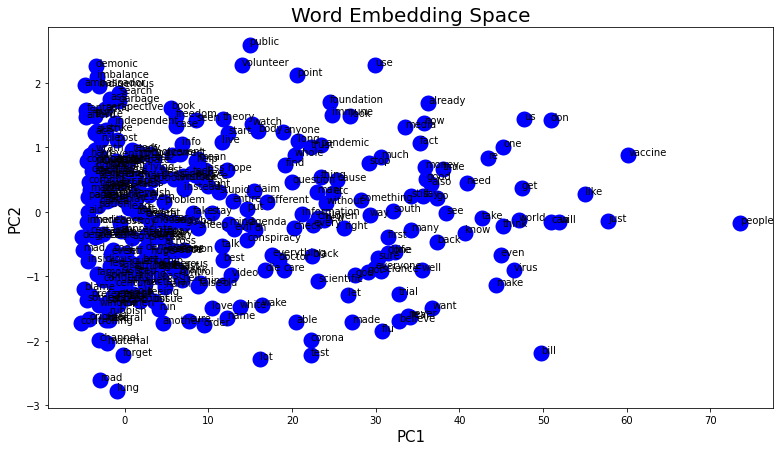

In [142]:
plotting_components_mod(reply_components,reply_vectors,300)

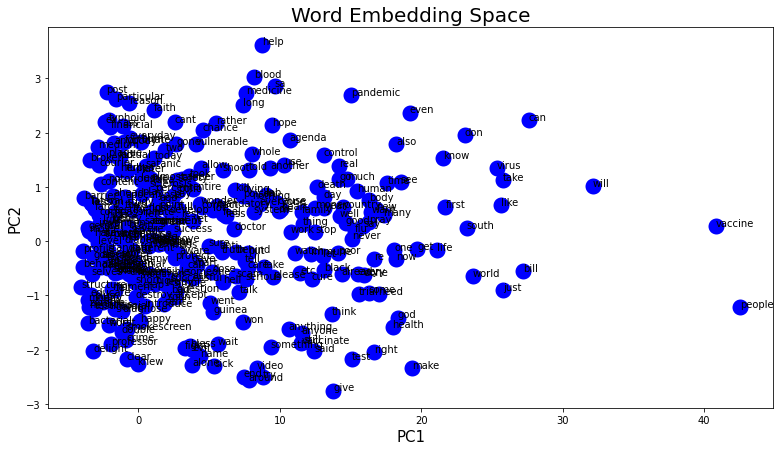

In [60]:
plotting_components_mod(comment_components,comment_vectors,300)

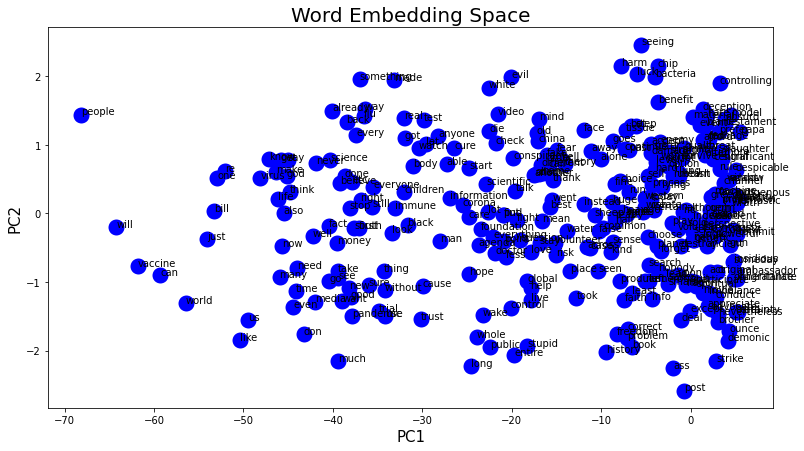

In [61]:
plotting_components_mod(combined_components,combined_vectors,300)

## Plotting the n close words to our word of interest 'Vaccine'. 

In [ ]:
# printing the learnt vocabulary
reply_words=list(reply_vectors.wv.vocab)
comment_words=list(comment_vectors.wv.vocab)
combined_words=list(combined_vectors.wv.vocab)


In [129]:
def word_distribution_around_target_word(target_word,n_surrounding_words,word_embeddings):
    """Function to pick the desired number of surrounding words around a word of interest to understand
    its contextual associations.
    Inputs:
    target_word: The word with whose contextual assications you'd want to understand
    n_surrounding_words: The n clossest words to the target word in the embedding dimension
    word_embeddings: word embeddings from gensim """
    
    surrounding_words = [word_embeddings.similar_by_word(target_word,topn = n_surrounding_words)[i][0] for i in range(n_surrounding_words)]
    words_for_plot = [target_word] + surrounding_words 
    X  = word_embeddings[words_for_plot]
    #Standardize for PCA
    X_standard = standard.fit_transform(X)
    #Creating dataframes with words as index and columns representing each embedding dimension
    df = pd.DataFrame(X_standard,index=words_for_plot)
    # PCA on dataframe
    components = pca(df)
    plotting_components(components,words_for_plot)

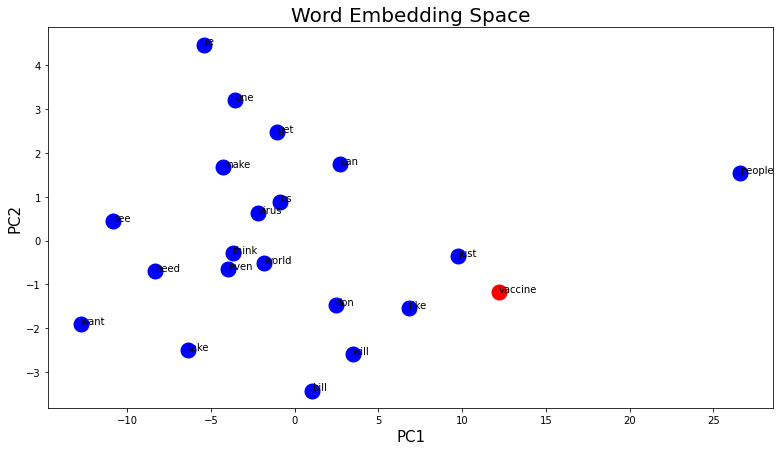

In [141]:
# Plot for words around vaccine in the replies corpus
word_distribution_around_target_word('vaccine',20,reply_vectors)

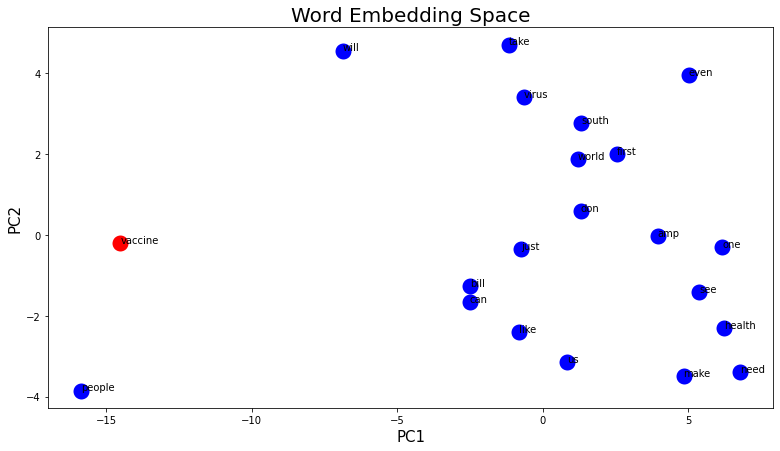

In [139]:
# Plot for words around vaccine in the comments corpus
word_distribution_around_target_word('vaccine',20,comment_vectors)

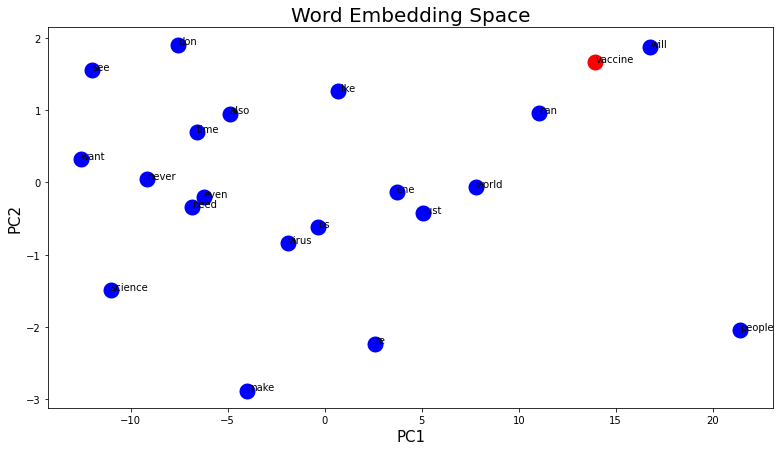

In [140]:
# Plot for words around vaccine in the combined corpus
word_distribution_around_target_word('vaccine',20,combined_vectors)